## Main Driver Notebook for Training Graph NN models on the Molecule Datasets

### MODELS
- GatedGCN 
- GCN 
- GAT 
- GraphSage 
- GIN  
- MoNet  
- MLP  
- RingGNN 
- 3WLGNN    

### DATASET
- ZINC Molecules    

### TASK
- Graph Regression

In [1]:
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import os
import socket
import time
import random
import glob
import argparse, json
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

In [2]:
# """
#     AUTORELOAD IPYTHON EXTENSION FOR RELOADING IMPORTED MODULES
# """

def in_ipynb():
    try:
        cfg = get_ipython().config 
        return True
    except NameError:
        return False
    
notebook_mode = in_ipynb()
print(notebook_mode)

if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2

True


In [3]:
"""
    IMPORTING CUSTOM MODULES/METHODS
"""
from nets.molecules_graph_regression.load_net import gnn_model # import all GNNS
from data.data import LoadData # import dataset

In [4]:
"""
    GPU Setup
"""
def gpu_setup(use_gpu, gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

    if torch.cuda.is_available() and use_gpu:
        print('cuda available with GPU:',torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        print('cuda not available')
        device = torch.device("cpu")
    return device


# select GPU or CPU
use_gpu = True; gpu_id = 3; device = None # default GPU
#use_gpu = False; gpu_id = -1; device = None # CPU

In [5]:
# """
#     USER CONTROLS
# """
if notebook_mode == True:
    
    #MODEL_NAME = '3WLGNN'
    #MODEL_NAME = 'RingGNN'
    #MODEL_NAME = 'GatedGCN'
    #MODEL_NAME = 'MoNet'
    #MODEL_NAME = 'GCN'
    #MODEL_NAME = 'GAT'
    MODEL_NAME = 'GATTop'
    # MODEL_NAME = 'GraphSage'
    # MODEL_NAME = 'DiffPool'
    # MODEL_NAME = 'MLP'
    # MODEL_NAME = 'GIN'

    DATASET_NAME = 'ZINC'

    out_dir = 'out/molecules_graph_regression/'
    root_log_dir = out_dir + 'logs/' + MODEL_NAME + "_" + DATASET_NAME + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    root_ckpt_dir = out_dir + 'checkpoints/' + MODEL_NAME + "_" + DATASET_NAME + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')

    print("[I] Loading data (notebook) ...")
    dataset = LoadData(DATASET_NAME)
    trainset, valset, testset = dataset.train, dataset.val, dataset.test
    print("[I] Finished loading.")

[I] Loading data (notebook) ...
[I] Loading dataset ZINC...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 13.5445s
[I] Finished loading.


In [6]:
#MODEL_NAME = 'RingGNN'
#MODEL_NAME = 'GatedGCN'
#MODEL_NAME = 'GCN'
#MODEL_NAME = 'GAT'
MODEL_NAME = 'GATTop'
#MODEL_NAME = 'GraphSage'
#MODEL_NAME = 'MLP'
#MODEL_NAME = 'DiffPool'
#MODEL_NAME = 'GIN'
#MODEL_NAME = 'MoNet'


In [7]:
# """
#     PARAMETERS
# """
if notebook_mode == True:

    n_heads = -1
    edge_feat = False
    pseudo_dim_MoNet = -1
    kernel = -1
    gnn_per_block = -1
    embedding_dim = -1
    pool_ratio = -1
    n_mlp_GIN = -1
    gated = False
    self_loop = False
    #self_loop = True
    max_time = 120
    pos_enc = True
    #pos_enc = False
    pos_enc_dim = 8
    
    if MODEL_NAME == 'GatedGCN':
        seed=41; epochs=1000; batch_size=5; init_lr=5e-5; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        L=4; hidden_dim=70; out_dim=hidden_dim; dropout=0.0; readout='mean'

    if MODEL_NAME == 'GCN':
        seed=41; epochs=1000; batch_size=5; init_lr=5e-5; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        L=4; hidden_dim=145; out_dim=hidden_dim; dropout=0.0; readout='mean'

    if MODEL_NAME == 'GAT':
        #seed=41; epochs=1000; batch_size=50; init_lr=5e-5; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        #L=4; n_heads=8; hidden_dim=18; out_dim=n_heads*hidden_dim; dropout=0.0; readout='mean'
        seed=341; epochs=1000; batch_size=128; init_lr=1e-3; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=4; n_heads=8; hidden_dim=18; out_dim=n_heads*hidden_dim; dropout=0.0; readout='mean'
        
        print('True hidden dim:',out_dim)
        
    if MODEL_NAME == 'GATTop':
        #seed=41; epochs=1000; batch_size=50; init_lr=5e-5; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        #L=4; n_heads=8; hidden_dim=18; out_dim=n_heads*hidden_dim; dropout=0.0; readout='mean'
        seed=241; epochs=1000; batch_size=128; init_lr=1e-3; lr_reduce_factor=0.5; lr_schedule_patience=10; min_lr = 1e-5; weight_decay=0
        L=4; n_heads=8; hidden_dim=18; out_dim=n_heads*hidden_dim; dropout=0.0; readout='mean'
        
        print('True hidden dim:',out_dim)

    if MODEL_NAME == 'GraphSage':
        seed=41; epochs=1000; batch_size=50; init_lr=5e-5; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        L=4; hidden_dim=108; out_dim=hidden_dim; dropout=0.0; readout='mean'

    if MODEL_NAME == 'MLP':
        seed=41; epochs=1000; batch_size=50; init_lr=5e-4; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        gated=False; # MEAN
        L=4; hidden_dim=150; out_dim=hidden_dim; dropout=0.0; readout='mean'
        gated=True; # GATED
        L=4; hidden_dim=135; out_dim=hidden_dim; dropout=0.0; readout='mean'
        
    if MODEL_NAME == 'DiffPool':
        seed=41; epochs=1000; batch_size=50; init_lr=5e-4; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        L=4; hidden_dim=56; out_dim=hidden_dim; dropout=0.0; readout='mean'
        n_heads=8; gnn_per_block=3; embedding_dim=hidden_dim; batch_size=128; pool_ratio=0.15

    if MODEL_NAME == 'GIN':
        seed=41; epochs=1000; batch_size=50; init_lr=5e-4; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        L=4; hidden_dim=110; out_dim=hidden_dim; dropout=0.0; readout='mean'
        n_mlp_GIN = 2; learn_eps_GIN=True; neighbor_aggr_GIN='sum'

    if MODEL_NAME == 'MoNet':
        seed=41; epochs=1000; batch_size=50; init_lr=5e-4; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        L=4; hidden_dim=90; out_dim=hidden_dim; dropout=0.0; readout='mean'
        pseudo_dim_MoNet=2; kernel=3;
    
    if MODEL_NAME == 'RingGNN':
        seed=41; epochs=1000; batch_size=1; init_lr=5e-5; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        #L=4; hidden_dim=145; out_dim=hidden_dim; dropout=0.0; readout='mean'
        L=4; hidden_dim=22; out_dim=hidden_dim; dropout=0.0; edge_feat=False
    
    if MODEL_NAME == '3WLGNN':
        seed=41; epochs=1000; batch_size=1; init_lr=5e-5; lr_reduce_factor=0.5; lr_schedule_patience=25; min_lr = 1e-6; weight_decay=0
        #L=4; hidden_dim=145; out_dim=hidden_dim; dropout=0.0; readout='mean'
        L=3; hidden_dim=79; out_dim=hidden_dim; dropout=0.0; edge_feat=False
        
        
    # generic new_params
    net_params = {}
    net_params['device'] = device
    net_params['num_atom_type'] = dataset.num_atom_type
    net_params['num_bond_type'] = dataset.num_bond_type
    net_params['residual'] = True
    net_params['hidden_dim'] = hidden_dim
    net_params['out_dim'] = out_dim
    net_params['n_heads'] = n_heads
    net_params['L'] = L  # min L should be 2
    net_params['readout'] = "sum"
    net_params['layer_norm'] = True
    net_params['batch_norm'] = True
    net_params['in_feat_dropout'] = 0.0
    net_params['dropout'] = 0.0
    net_params['edge_feat'] = edge_feat
    net_params['self_loop'] = self_loop

    # for MLPNet 
    net_params['gated'] = gated  
    
    # specific for MoNet
    net_params['pseudo_dim_MoNet'] = pseudo_dim_MoNet
    net_params['kernel'] = kernel
    
    # specific for GIN
    net_params['n_mlp_GIN'] = n_mlp_GIN
    net_params['learn_eps_GIN'] = True
    net_params['neighbor_aggr_GIN'] = 'sum'
    
    # specific for graphsage
    net_params['sage_aggregator'] = 'meanpool'    

    # specific for diffpoolnet
    net_params['data_mode'] = 'default'
    net_params['gnn_per_block'] = gnn_per_block
    net_params['embedding_dim'] = embedding_dim     
    net_params['pool_ratio'] = pool_ratio
    net_params['linkpred'] = True
    net_params['num_pool'] = 1
    net_params['cat'] = False
    net_params['batch_size'] = batch_size   
    
    # specific for RingGNN
    net_params['radius'] = 2
    num_nodes = [trainset[i][0].number_of_nodes() for i in range(len(trainset))]
    net_params['avg_node_num'] = int(np.ceil(np.mean(num_nodes)))
    
    # specific for 3WLGNN
    net_params['depth_of_mlp'] = 2

    # calculate assignment dimension: pool_ratio * largest graph's maximum
    # number of nodes  in the dataset
    max_num_node = max(num_nodes)
    net_params['assign_dim'] = int(max_num_node * net_params['pool_ratio']) * net_params['batch_size']
    
    # specific for pos_enc_dim
    net_params['pos_enc'] = pos_enc
    net_params['pos_enc_dim'] = pos_enc_dim
    

True hidden dim: 144


In [8]:
"""
    VIEWING MODEL CONFIG AND PARAMS
"""
def view_model_param(MODEL_NAME, net_params):
    model = gnn_model(MODEL_NAME, net_params)
    total_param = 0
    print("MODEL DETAILS:\n")
    #print(model)
    for param in model.parameters():
        # print(param.data.size())
        total_param += np.prod(list(param.data.size()))
    print('MODEL/Total parameters:', MODEL_NAME, total_param)
    return total_param


if notebook_mode == True:
    view_model_param(MODEL_NAME, net_params)

extra_global_feats 2
MODEL DETAILS:

MODEL/Total parameters: GATTop 106017


In [9]:
"""
    TRAINING CODE
"""

def train_val_pipeline(MODEL_NAME, dataset, params, net_params, dirs):
    t0 = time.time()
    per_epoch_time = []
        
    DATASET_NAME = dataset.name
    
    if MODEL_NAME in ['GCN', 'GAT']:
        if net_params['self_loop']:
            print("[!] Adding graph self-loops for GCN/GAT models (central node trick).")
            dataset._add_self_loops()
            
    if MODEL_NAME in ['GatedGCN']:
        if net_params['pos_enc']:
            print("[!] Adding graph positional encoding.")
            dataset._add_positional_encodings(net_params['pos_enc_dim'])
            print('Time PE:',time.time()-t0)
        
    trainset, valset, testset = dataset.train, dataset.val, dataset.test
        
    root_log_dir, root_ckpt_dir, write_file_name, write_config_file = dirs
    device = net_params['device']
    
    # Write the network and optimization hyper-parameters in folder config/
    with open(write_config_file + '.txt', 'w') as f:
        f.write("""Dataset: {},\nModel: {}\n\nparams={}\n\nnet_params={}\n\n\nTotal Parameters: {}\n\n"""\
                .format(DATASET_NAME, MODEL_NAME, params, net_params, net_params['total_param']))
        
    log_dir = os.path.join(root_log_dir, "RUN_" + str(0))
    writer = SummaryWriter(log_dir=log_dir)

    # setting seeds
    random.seed(params['seed'])
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    if device.type == 'cuda':
        torch.cuda.manual_seed(params['seed'])
    
    print("Training Graphs: ", len(trainset))
    print("Validation Graphs: ", len(valset))
    print("Test Graphs: ", len(testset))

    model = gnn_model(MODEL_NAME, net_params)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=params['init_lr'], weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=params['lr_reduce_factor'],
                                                     patience=params['lr_schedule_patience'],
                                                     verbose=True)
    
    epoch_train_losses, epoch_val_losses = [], []
    epoch_train_MAEs, epoch_val_MAEs = [], [] 
    
    # batching exception for Diffpool
    drop_last = True if MODEL_NAME == 'DiffPool' else False
    
    if MODEL_NAME in ['RingGNN', '3WLGNN']:
        # import train functions specific for WLGNNs
        from train.train_molecules_graph_regression import train_epoch_dense as train_epoch, evaluate_network_dense as evaluate_network
        from functools import partial # util function to pass edge_feat to collate function

        train_loader = DataLoader(trainset, shuffle=True, collate_fn=partial(dataset.collate_dense_gnn, edge_feat=net_params['edge_feat']))
        val_loader = DataLoader(valset, shuffle=False, collate_fn=partial(dataset.collate_dense_gnn, edge_feat=net_params['edge_feat']))
        test_loader = DataLoader(testset, shuffle=False, collate_fn=partial(dataset.collate_dense_gnn, edge_feat=net_params['edge_feat']))
        
    else:
        # import train functions for all other GNNs
        from train.train_molecules_graph_regression import train_epoch_sparse as train_epoch, evaluate_network_sparse as evaluate_network
        
        train_loader = DataLoader(trainset, batch_size=params['batch_size'], shuffle=True, drop_last=drop_last, collate_fn=dataset.collate)
        val_loader = DataLoader(valset, batch_size=params['batch_size'], shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
        test_loader = DataLoader(testset, batch_size=params['batch_size'], shuffle=False, drop_last=drop_last, collate_fn=dataset.collate)
    
    # At any point you can hit Ctrl + C to break out of training early.
    try:
        with tqdm(range(params['epochs'])) as t:
            for epoch in t:

                t.set_description('Epoch %d' % epoch)

                start = time.time()

                if MODEL_NAME in ['RingGNN', '3WLGNN']: # since different batch training function for RingGNN
                    epoch_train_loss, epoch_train_mae, optimizer = train_epoch(model, optimizer, device, train_loader, epoch, params['batch_size'])
                else:   # for all other models common train function
                    epoch_train_loss, epoch_train_mae, optimizer = train_epoch(model, optimizer, device, train_loader, epoch)
                    
                epoch_val_loss, epoch_val_mae = evaluate_network(model, device, val_loader, epoch)
                _, epoch_test_mae = evaluate_network(model, device, test_loader, epoch)
                
                epoch_train_losses.append(epoch_train_loss)
                epoch_val_losses.append(epoch_val_loss)
                epoch_train_MAEs.append(epoch_train_mae)
                epoch_val_MAEs.append(epoch_val_mae)

                writer.add_scalar('train/_loss', epoch_train_loss, epoch)
                writer.add_scalar('val/_loss', epoch_val_loss, epoch)
                writer.add_scalar('train/_mae', epoch_train_mae, epoch)
                writer.add_scalar('val/_mae', epoch_val_mae, epoch)
                writer.add_scalar('test/_mae', epoch_test_mae, epoch)
                writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)

                        
                t.set_postfix(time=time.time()-start, lr=optimizer.param_groups[0]['lr'],
                              train_loss=epoch_train_loss, val_loss=epoch_val_loss,
                              train_MAE=epoch_train_mae, val_MAE=epoch_val_mae,
                              test_MAE=epoch_test_mae)


                per_epoch_time.append(time.time()-start)

                # Saving checkpoint
                ckpt_dir = os.path.join(root_ckpt_dir, "RUN_")
                if not os.path.exists(ckpt_dir):
                    os.makedirs(ckpt_dir)
                torch.save(model.state_dict(), '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch)))

                files = glob.glob(ckpt_dir + '/*.pkl')
                for file in files:
                    epoch_nb = file.split('_')[-1]
                    epoch_nb = int(epoch_nb.split('.')[0])
                    if epoch_nb < epoch-1:
                        os.remove(file)

                scheduler.step(epoch_val_loss)

                if optimizer.param_groups[0]['lr'] < params['min_lr']:
                    print("\n!! LR EQUAL TO MIN LR SET.")
                    break
                
                # Stop training after params['max_time'] hours
                if time.time()-t0 > params['max_time']*3600:
                    print('-' * 89)
                    print("Max_time for training elapsed {:.2f} hours, so stopping".format(params['max_time']))
                    break
                
    except KeyboardInterrupt:
        print('-' * 89)
        print('Exiting from training early because of KeyboardInterrupt')
    
    _, test_mae = evaluate_network(model, device, test_loader, epoch)
    _, train_mae = evaluate_network(model, device, train_loader, epoch)
    print("Test MAE: {:.4f}".format(test_mae))
    print("Train MAE: {:.4f}".format(train_mae))
    print("Convergence Time (Epochs): {:.4f}".format(epoch))
    print("TOTAL TIME TAKEN: {:.4f}s".format(time.time()-t0))
    print("AVG TIME PER EPOCH: {:.4f}s".format(np.mean(per_epoch_time)))

    writer.close()

    """
        Write the results in out_dir/results folder
    """
    with open(write_file_name + '.txt', 'w') as f:
        f.write("""Dataset: {},\nModel: {}\n\nparams={}\n\nnet_params={}\n\n{}\n\nTotal Parameters: {}\n\n
    FINAL RESULTS\nTEST MAE: {:.4f}\nTRAIN MAE: {:.4f}\n\n
    Convergence Time (Epochs): {:.4f}\nTotal Time Taken: {:.4f} hrs\nAverage Time Per Epoch: {:.4f} s\n\n\n"""\
          .format(DATASET_NAME, MODEL_NAME, params, net_params, model, net_params['total_param'],
                  test_mae, train_mae, epoch, (time.time()-t0)/3600, np.mean(per_epoch_time)))
        

In [10]:
def main(notebook_mode=False,config=None):
    
    """
        USER CONTROLS
    """
    
    # terminal mode
    if notebook_mode==False:
        
        parser = argparse.ArgumentParser()
        parser.add_argument('--config', help="Please give a config.json file with training/model/data/param details")
        parser.add_argument('--gpu_id', help="Please give a value for gpu id")
        parser.add_argument('--model', help="Please give a value for model name")
        parser.add_argument('--dataset', help="Please give a value for dataset name")
        parser.add_argument('--out_dir', help="Please give a value for out_dir")
        parser.add_argument('--seed', help="Please give a value for seed")
        parser.add_argument('--epochs', help="Please give a value for epochs")
        parser.add_argument('--batch_size', help="Please give a value for batch_size")
        parser.add_argument('--init_lr', help="Please give a value for init_lr")
        parser.add_argument('--lr_reduce_factor', help="Please give a value for lr_reduce_factor")
        parser.add_argument('--lr_schedule_patience', help="Please give a value for lr_schedule_patience")
        parser.add_argument('--min_lr', help="Please give a value for min_lr")
        parser.add_argument('--weight_decay', help="Please give a value for weight_decay")
        parser.add_argument('--print_epoch_interval', help="Please give a value for print_epoch_interval")    
        parser.add_argument('--L', help="Please give a value for L")
        parser.add_argument('--hidden_dim', help="Please give a value for hidden_dim")
        parser.add_argument('--out_dim', help="Please give a value for out_dim")
        parser.add_argument('--residual', help="Please give a value for residual")
        parser.add_argument('--edge_feat', help="Please give a value for edge_feat")
        parser.add_argument('--readout', help="Please give a value for readout")
        parser.add_argument('--kernel', help="Please give a value for kernel")
        parser.add_argument('--n_heads', help="Please give a value for n_heads")
        parser.add_argument('--gated', help="Please give a value for gated")
        parser.add_argument('--in_feat_dropout', help="Please give a value for in_feat_dropout")
        parser.add_argument('--dropout', help="Please give a value for dropout")
        parser.add_argument('--layer_norm', help="Please give a value for layer_norm")
        parser.add_argument('--batch_norm', help="Please give a value for batch_norm")
        parser.add_argument('--sage_aggregator', help="Please give a value for sage_aggregator")
        parser.add_argument('--data_mode', help="Please give a value for data_mode")
        parser.add_argument('--num_pool', help="Please give a value for num_pool")
        parser.add_argument('--gnn_per_block', help="Please give a value for gnn_per_block")
        parser.add_argument('--embedding_dim', help="Please give a value for embedding_dim")
        parser.add_argument('--pool_ratio', help="Please give a value for pool_ratio")
        parser.add_argument('--linkpred', help="Please give a value for linkpred")
        parser.add_argument('--cat', help="Please give a value for cat")
        parser.add_argument('--self_loop', help="Please give a value for self_loop")
        parser.add_argument('--max_time', help="Please give a value for max_time")
        parser.add_argument('--pos_enc_dim', help="Please give a value for pos_enc_dim")
        parser.add_argument('--pos_enc', help="Please give a value for pos_enc")
        args = parser.parse_args()
        with open(args.config) as f:
            config = json.load(f)
            
        # device
        if args.gpu_id is not None:
            config['gpu']['id'] = int(args.gpu_id)
            config['gpu']['use'] = True
        device = gpu_setup(config['gpu']['use'], config['gpu']['id'])

        # model, dataset, out_dir
        if args.model is not None:
            MODEL_NAME = args.model
        else:
            MODEL_NAME = config['model']
        if args.dataset is not None:
            DATASET_NAME = args.dataset
        else:
            DATASET_NAME = config['dataset']
        dataset = LoadData(DATASET_NAME)
        if args.out_dir is not None:
            out_dir = args.out_dir
        else:
            out_dir = config['out_dir']

        # parameters
        params = config['params']
        if args.seed is not None:
            params['seed'] = int(args.seed)
        if args.epochs is not None:
            params['epochs'] = int(args.epochs)
        if args.batch_size is not None:
            params['batch_size'] = int(args.batch_size)
        if args.init_lr is not None:
            params['init_lr'] = float(args.init_lr)
        if args.lr_reduce_factor is not None:
            params['lr_reduce_factor'] = float(args.lr_reduce_factor)
        if args.lr_schedule_patience is not None:
            params['lr_schedule_patience'] = int(args.lr_schedule_patience)
        if args.min_lr is not None:
            params['min_lr'] = float(args.min_lr)
        if args.weight_decay is not None:
            params['weight_decay'] = float(args.weight_decay)
        if args.print_epoch_interval is not None:
            params['print_epoch_interval'] = int(args.print_epoch_interval)
        if args.max_time is not None:
            params['max_time'] = float(args.max_time)

        # network parameters
        net_params = config['net_params']
        net_params['device'] = device
        net_params['gpu_id'] = config['gpu']['id']
        net_params['batch_size'] = params['batch_size']
        if args.L is not None:
            net_params['L'] = int(args.L)
        if args.hidden_dim is not None:
            net_params['hidden_dim'] = int(args.hidden_dim)
        if args.out_dim is not None:
            net_params['out_dim'] = int(args.out_dim)   
        if args.residual is not None:
            net_params['residual'] = True if args.residual=='True' else False
        if args.edge_feat is not None:
            net_params['edge_feat'] = True if args.edge_feat=='True' else False
        if args.readout is not None:
            net_params['readout'] = args.readout
        if args.kernel is not None:
            net_params['kernel'] = int(args.kernel)
        if args.n_heads is not None:
            net_params['n_heads'] = int(args.n_heads)
        if args.gated is not None:
            net_params['gated'] = True if args.gated=='True' else False
        if args.in_feat_dropout is not None:
            net_params['in_feat_dropout'] = float(args.in_feat_dropout)
        if args.dropout is not None:
            net_params['dropout'] = float(args.dropout)
        if args.layer_norm is not None:
            net_params['layer_norm'] = True if args.layer_norm=='True' else False
        if args.batch_norm is not None:
            net_params['batch_norm'] = True if args.batch_norm=='True' else False
        if args.sage_aggregator is not None:
            net_params['sage_aggregator'] = args.sage_aggregator
        if args.data_mode is not None:
            net_params['data_mode'] = args.data_mode
        if args.num_pool is not None:
            net_params['num_pool'] = int(args.num_pool)
        if args.gnn_per_block is not None:
            net_params['gnn_per_block'] = int(args.gnn_per_block)
        if args.embedding_dim is not None:
            net_params['embedding_dim'] = int(args.embedding_dim)
        if args.pool_ratio is not None:
            net_params['pool_ratio'] = float(args.pool_ratio)
        if args.linkpred is not None:
            net_params['linkpred'] = True if args.linkpred=='True' else False
        if args.cat is not None:
            net_params['cat'] = True if args.cat=='True' else False
        if args.self_loop is not None:
            net_params['self_loop'] = True if args.self_loop=='True' else False
        if args.pos_enc is not None:
            net_params['pos_enc'] = True if args.pos_enc=='True' else False
        if args.pos_enc_dim is not None:
            net_params['pos_enc_dim'] = int(args.pos_enc_dim)

            
    # notebook mode
    if notebook_mode:
        
        # parameters
        params = config['params']
        
        # dataset
        DATASET_NAME = config['dataset']
        dataset = LoadData(DATASET_NAME)
        
        # device
        device = gpu_setup(config['gpu']['use'], config['gpu']['id'])
        out_dir = config['out_dir']
        
        # GNN model
        MODEL_NAME = config['model']
        
        # network parameters
        net_params = config['net_params']
        net_params['device'] = device
        net_params['gpu_id'] = config['gpu']['id']
        net_params['batch_size'] = params['batch_size']
        
    
    # ZINC
    net_params['num_atom_type'] = dataset.num_atom_type
    net_params['num_bond_type'] = dataset.num_bond_type

    
    if MODEL_NAME == 'DiffPool':
        # calculate assignment dimension: pool_ratio * largest graph's maximum
        # number of nodes  in the dataset
        num_nodes = [dataset.train[i][0].number_of_nodes() for i in range(len(dataset.train))]
        max_num_node = max(num_nodes)
        net_params['assign_dim'] = int(max_num_node * net_params['pool_ratio']) * net_params['batch_size']
        
    if MODEL_NAME == 'RingGNN':
        num_nodes = [dataset.train[i][0].number_of_nodes() for i in range(len(dataset.train))]
        net_params['avg_node_num'] = int(np.ceil(np.mean(num_nodes)))
    
    root_log_dir = out_dir + 'logs/' + MODEL_NAME + "_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    root_ckpt_dir = out_dir + 'checkpoints/' + MODEL_NAME + "_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    write_file_name = out_dir + 'results/result_' + MODEL_NAME + "_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    write_config_file = out_dir + 'configs/config_' + MODEL_NAME + "_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    dirs = root_log_dir, root_ckpt_dir, write_file_name, write_config_file

    if not os.path.exists(out_dir + 'results'):
        os.makedirs(out_dir + 'results')
        
    if not os.path.exists(out_dir + 'configs'):
        os.makedirs(out_dir + 'configs')

    net_params['total_param'] = view_model_param(MODEL_NAME, net_params)
    train_val_pipeline(MODEL_NAME, dataset, params, net_params, dirs)

    
    
    
    
    
    
if notebook_mode==True:
    
    config = {}
    # gpu config
    gpu = {}
    gpu['use'] = use_gpu
    gpu['id'] = gpu_id
    config['gpu'] = gpu
    # GNN model, dataset, out_dir
    config['model'] = MODEL_NAME
    config['dataset'] = DATASET_NAME
    config['out_dir'] = out_dir
    # parameters
    params = {}
    params['seed'] = seed
    params['epochs'] = epochs
    params['batch_size'] = batch_size
    params['init_lr'] = init_lr
    params['lr_reduce_factor'] = lr_reduce_factor 
    params['lr_schedule_patience'] = lr_schedule_patience
    params['min_lr'] = min_lr
    params['weight_decay'] = weight_decay
    params['print_epoch_interval'] = 5
    params['max_time'] = max_time
    config['params'] = params
    # network parameters
    config['net_params'] = net_params
    
    # convert to .py format
    from utils.cleaner_main import *
    cleaner_main('main_molecules_graph_regression')
    
    main(True,config)
    
else:
    
    main()
    

Convert main_molecules_graph_regression.ipynb to main_molecules_graph_regression.py


[NbConvertApp] Converting notebook main_molecules_graph_regression.ipynb to script
[NbConvertApp] Writing 28874 bytes to main_molecules_graph_regression.py


Clean main_molecules_graph_regression.py
Done. 
[I] Loading dataset ZINC...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 14.9736s
cuda available with GPU: NVIDIA TITAN RTX
extra_global_feats 2
MODEL DETAILS:

MODEL/Total parameters: GATTop 106017
Training Graphs:  10000
Validation Graphs:  1000
Test Graphs:  1000
extra_global_feats 2


Epoch 45:   4%|▏  | 45/1000 [11:15<4:01:10, 15.15s/it, lr=0.001, test_MAE=0.687, time=15.3, train_MAE=0.422, train_loss=0.422, val_MAE=0.651, val_loss=0.651]

Epoch 00045: reducing learning rate of group 0 to 5.0000e-04.


Epoch 61:   6%|▏   | 61/1000 [15:18<3:56:21, 15.10s/it, lr=0.0005, test_MAE=0.483, time=15, train_MAE=0.371, train_loss=0.371, val_MAE=0.468, val_loss=0.468]

Epoch 00061: reducing learning rate of group 0 to 2.5000e-04.


Epoch 77:   8%|▎   | 77/1000 [19:21<3:52:30, 15.11s/it, lr=0.00025, test_MAE=0.47, time=15, train_MAE=0.338, train_loss=0.338, val_MAE=0.451, val_loss=0.451]

Epoch 00077: reducing learning rate of group 0 to 1.2500e-04.


Epoch 88:   9%| | 88/1000 [22:07<3:50:53, 15.19s/it, lr=0.000125, test_MAE=0.469, time=15.5, train_MAE=0.325, train_loss=0.325, val_MAE=0.456, val_loss=0.456

Epoch 00088: reducing learning rate of group 0 to 6.2500e-05.


Epoch 108:  11%|▏ | 108/1000 [27:12<3:45:48, 15.19s/it, lr=6.25e-5, test_MAE=0.47, time=15, train_MAE=0.316, train_loss=0.316, val_MAE=0.451, val_loss=0.451]

Epoch 00108: reducing learning rate of group 0 to 3.1250e-05.


Epoch 119:  12%| | 119/1000 [29:59<3:43:13, 15.20s/it, lr=3.13e-5, test_MAE=0.469, time=15.1, train_MAE=0.312, train_loss=0.312, val_MAE=0.448, val_loss=0.44

Epoch 00119: reducing learning rate of group 0 to 1.5625e-05.


Epoch 129:  13%|▏| 129/1000 [32:47<3:41:25, 15.25s/it, lr=1.56e-5, test_MAE=0.468, time=15.3, train_MAE=0.315, train_loss=0.315, val_MAE=0.45, val_loss=0.45]


Epoch 00130: reducing learning rate of group 0 to 7.8125e-06.

!! LR EQUAL TO MIN LR SET.
Test MAE: 0.4684
Train MAE: 0.3004
Convergence Time (Epochs): 129.0000
TOTAL TIME TAKEN: 1982.1099s
AVG TIME PER EPOCH: 15.1236s


In [11]:
DATASET_NAME = config['dataset']
dataset = LoadData(DATASET_NAME)

[I] Loading dataset ZINC...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 16.1823s


In [12]:
trainset, valset, testset = dataset.train, dataset.val, dataset.test

In [13]:
len(trainset)

10000

In [14]:
for g in trainset:
    print(g[0].num_nodes() / g[0].num_edges()*2)

0.90625
0.9285714285714286
0.9411764705882353
0.9
0.9545454545454546
0.9333333333333333
1.0
1.0
0.9565217391304348
0.9473684210526315
0.9583333333333334
0.9230769230769231
0.9444444444444444
0.8947368421052632
0.9473684210526315
0.9090909090909091
0.896551724137931
0.896551724137931
0.9545454545454546
0.9230769230769231
0.9310344827586207
0.9230769230769231
0.8846153846153846
0.90625
0.8857142857142857
1.0588235294117647
0.96
1.0
0.9411764705882353
0.9117647058823529
0.9629629629629629
0.8918918918918919
0.9166666666666666
0.9166666666666666
0.9333333333333333
0.9285714285714286
0.9565217391304348
0.9615384615384616
1.0
0.9565217391304348
0.96
0.9523809523809523
0.9090909090909091
0.9473684210526315
0.9523809523809523
0.8888888888888888
0.90625
0.92
0.9523809523809523
0.9230769230769231
0.9130434782608695
0.9047619047619048
0.9130434782608695
0.896551724137931
0.9230769230769231
0.9130434782608695
0.92
0.90625
0.8928571428571429
0.9285714285714286
0.9523809523809523
0.9090909090909091


In [15]:
g = trainset[25]

In [16]:
g

(Graph(num_nodes=18, num_edges=34,
       ndata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(), dtype=torch.int64)}),
 tensor([-0.0582]))

In [17]:
g_nx = dgl.to_networkx(g[0])

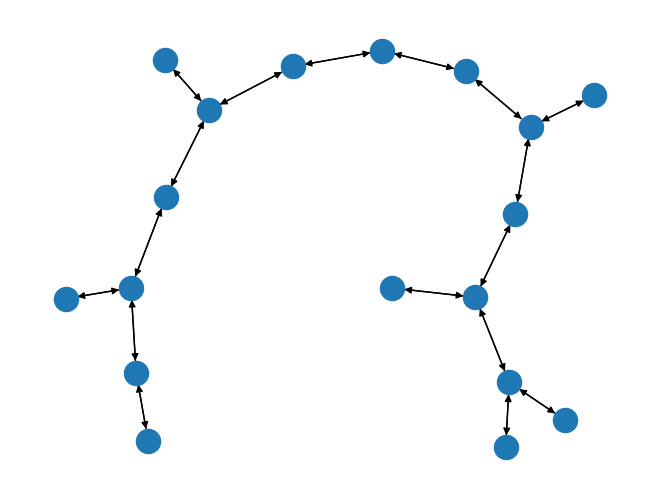

In [18]:
import networkx as nx
import torch_geometric

nx.draw(g_nx)

In [19]:
for elem in zip(g[0].edges()[0], g[0].edges()[1]):
    
    v1, v2 = elem[0].item(), elem[1].item()
    
    if v1 < v2:
        c[(v1, v2)] += 1
    else:
        c[(v2, v1)] += 1

NameError: name 'c' is not defined

In [ ]:
c

In [ ]:
elem[0].item()

In [ ]:
c

In [ ]:
from torch_scatter import scatter

In [ ]:
src = torch.tensor([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])
idx = torch.tensor([[0, 1, 0, 0, 0], [0, 1, 0, 0, 0]])

In [ ]:
out = scatter(src, idx, reduce = 'sum')

In [ ]:
out